**OBJECTIVE:** What are modSAR's pIC50 predictions for this set of OSM Series4-derived compounds listed [here](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/29)?

**DATE:** 22/07/2021

**AUTHOR:** @jonjoncardoso

**REFERENCE:**

> _Cardoso-Silva, J., Papageorgiou, L. G. & Tsoka, S. **Network-based piecewise linear regression for QSAR modelling.** J. Comput. Aided. Mol. Des. 33, 831–844 (2019). http://link.springer.com/10.1007/s10822-019-00228-6_

**NOTE:** The current implementation of the algorithm is different to [the one I used in OSM-S4 competition](https://chemrxiv.org/engage/chemrxiv/article-details/60c751a59abda283a4f8dc53). We're almost finished drafting a paper about this, I will be able to share soon.

In [1]:
import math
import igraph
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
import modSAR
from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDataset, QSARDatasetIO

# plotnine is the python version of ggplot2
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from rdkit import RDLogger

import rdkit.Geometry
from rdkit.Chem import rdFMCS, PandasTools
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import PandasTools

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

s4_template = Chem.MolFromSmarts('[#6]1:[#7]:[#6]:[#6]:[#7]2:[#6]:1:[#7]:[#7]:[#6]:2')
AllChem.Compute2DCoords(s4_template)

RDLogger.DisableLog('rdApp.info')

from rdkit.Chem import PandasTools

%matplotlib inline

# Preprocessing

## Data Input

In [2]:
# Place spreadsheet under ./data
X = pd.read_excel('/mnt/data/Master Chemical List - new.xlsx')

# Compound OSM-S-424 cannot be parsed by RDKit so we remove it from our dataset
X = X[X["OSM_ID"] != 'OSM-S-424'].copy()

# Activity data is represented by the column `Value` (in uM). Calculate pIC50 from this column:
X['pIC50'] = -np.log10(X['Value']* 1e-06)

# Save this preprocessed dataset to the ./data folder
X.to_excel('/mnt/data/osm_raw_dataset_2021_07_21.xlsx', index = False)

## Read data above into modSAR package

In [3]:
from modSAR.datasource import GenericFileDataSource

# Read the bioactivities in a more standard way with modSAR package

osm_dataset = GenericFileDataSource(target_id='malaria_osm4', 
                                    filepath='/mnt/data/osm_raw_dataset_2021_07_21.xlsx', 
                                    smiles_column='Canonical_Smiles', 
                                    compound_id_column='OSM_ID', 
                                    activity_column='pIC50',
                                    apply_filter=False)

print("Number of compounds: %d | Number of unique compounds: %d" %
      (osm_dataset.bioactivities_df.shape[0], osm_dataset.bioactivities_df['OSM_ID'].nunique()))

Number of compounds: 477 | Number of unique compounds: 386


In [5]:
# Have a look at the dataframe
osm_dataset.bioactivities_df.head(3)

,OSM_ID,Series,Canonical_Smiles,InChIKey,Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),Assay,Value,Qualifier,pIC50
0,OSM-S-5,1,Cc1cc(C(=O)OCC(N)=O)c(C)n1-c1ccc(F)cc1,YSUCFIZUNLQZDX-UHFFFAOYSA-N,0.818; 0.177,NaN,NaN,0.404,0.375,0.61,NaN,NaN,0.581,0.641,NaN,NaN,Pfal IC50 (GSK),0.818,0,6.087247
1,OSM-S-5,1,Cc1cc(C(=O)OCC(N)=O)c(C)n1-c1ccc(F)cc1,YSUCFIZUNLQZDX-UHFFFAOYSA-N,0.818; 0.177,NaN,NaN,0.404,0.375,0.61,NaN,NaN,0.581,0.641,NaN,NaN,Pfal IC50 (GSK),0.177,0,6.752027
2,OSM-S-5,1,Cc1cc(C(=O)OCC(N)=O)c(C)n1-c1ccc(F)cc1,YSUCFIZUNLQZDX-UHFFFAOYSA-N,0.818; 0.177,NaN,NaN,0.404,0.375,0.61,NaN,NaN,0.581,0.641,NaN,NaN,Pfal IC50 (Avery),0.404,0,6.393619


<AxesSubplot:>

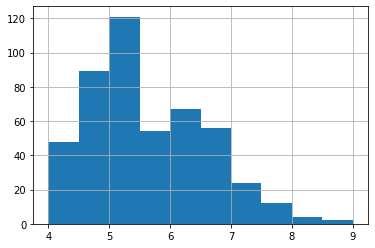

In [6]:
# Quick look into the distribution of pIC50 activity
osm_dataset.bioactivities_df['pIC50'].hist()

## Fingerprinting

In [7]:
osm_morgan4_dataset = osm_dataset.build_qsar_dataset(type="morgan4", calculate_similarity=False)

**Save dataset**

In [8]:
QSARDatasetIO.write(osm_morgan4_dataset, filepath='/mnt/data/osm_qsar_dataset_morgan4.xlsx')

## Create dataset for ML

In [4]:
dataset_morgan4 = \
    QSARDatasetIO.load(dataset_name='OSM4',
                       activity_sheetname='activity',
                       smiles_column='Canonical_Smiles',
                       id_column='OSM_ID',
                       filepath='/mnt/data/osm_qsar_dataset_morgan4.xlsx',
                       calculate_similarity=False)

# Model Fitting

In [16]:
modsar_alg = ModSAR(lam=0.005, metadata=dataset_morgan4.metadata, solver_name="glpk")
modsar_alg.fit(dataset_morgan4.X, dataset_morgan4.y)

**Save resulting network**

In [14]:
igraph.save(modsar_alg.instance_graph, "/mnt/data/model_modsar_morgan4_graph.gml")

**Plot network**

In [20]:
from nx_altair.core import to_pandas_nodes

#TODO: In the future, reduce reading and writing by using only one network framework, either igraph or networkx
G = nx.read_gml("/mnt/data/model_modsar_morgan4_graph.gml")
pos = nx.kamada_kawai_layout(G, scale=0.6)

In [43]:
molecules_df = to_pandas_nodes(G, pos)

molecules_df = pd.merge(molecules_df, 
                        dataset_morgan4.metadata[["Series", "Canonical_Smiles"]], 
                        left_index=True, 
                        right_index=True)

molecules_df.head()

,louvain,y,x,community,degree,Series,Canonical_Smiles
OSM-S-5,m01,0.110772,0.312699,m01,23,1,Cc1cc(C(=O)OCC(N)=O)c(C)n1-c1ccc(F)cc1
OSM-L-1,m01,0.134794,0.569626,m01,28,1,Cc1cc(/C=C2\S/C(=N\c3ccccc3)N(c3ccccc3)C2=O)c(...
OSM-S-109,m01,0.212031,0.564901,m01,28,1,Cc1cc(/C=C2\S/C(=N\c3ccccc3)NC2=O)c(C)n1-c1ccc...
OSM-S-110,m01,0.217593,0.535778,m01,28,1,Cc1cc(/C=C2\S/C(=N\c3cccc(O)c3)NC2=O)c(C)n1-c1...
OSM-S-111,m01,0.255197,0.542157,m01,28,1,COc1ccc(-n2c(C)cc(/C=C3\S/C(=N\c4ccccc4)NC3=O)...


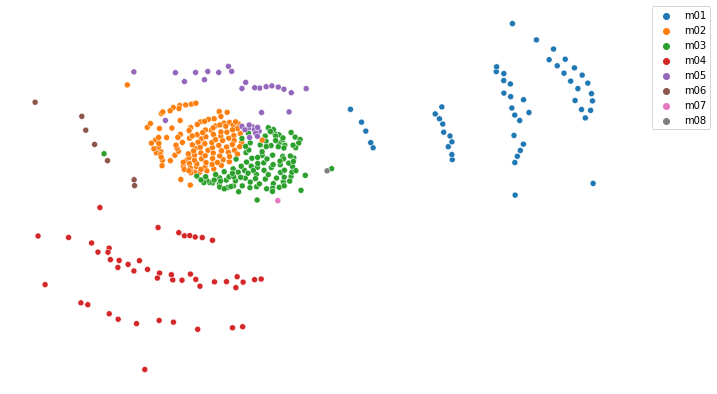

In [44]:
plt.figure(figsize=[11,7])

net_plot = sns.scatterplot(data =  molecules_df, x = 'x', y = 'y', hue = 'community')

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)

net_plot.set(xticklabels=[]) 
net_plot.set(xlabel=None)
net_plot.tick_params(bottom=False)  # remove the ticks

net_plot.set(yticklabels=[]) 
net_plot.set(ylabel=None)
net_plot.tick_params(left=False)  # remove the ticks

plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

**Correspondence of modules above to OSM Series**

In [45]:
osm_series = molecules_df.Series
osm_series = osm_series.apply(lambda x: '4' if x == 'not4' else ('1' if x == 'TB' else x))
osm_series.name = "OSM Data"
osm_series = osm_series.apply(lambda x: 'Series '+x)

modules = molecules_df.community
modules.name = "Modules"

pd.crosstab(modules, osm_series)

OSM Data,Series 1,Series 2,Series 3,Series 4
Modules,,,,
m01,52,0,0,0
m02,0,1,0,128
m03,0,0,0,115
m04,0,0,48,0
m05,0,0,0,33
m06,0,0,0,7
m07,1,0,0,0
m08,0,0,1,0


# Load generated molecules

In [10]:
gen_df = pd.read_csv("/mnt/data/enamine_boronics_virtual_lib.csv")
gen_df = gen_df.rename(columns={"smiles": "canonical_smiles","Unnamed: 0": "original_id"})
gen_df.head(4)

,original_id,canonical_smiles,potency_mu,potency_sigma,LogD_mu,LogD_sigma,potency_prob_success,LogD_prob_success,prob_success
0,1976,Fc1ccc(CCOc2cncc3nnc(-c4cnc5[nH]ccc5c4)n23)cc1F,6.410090,0.511403,2.586254,0.626126,0.129416,0.961385,0.124418
1,1600,Fc1ccc(CCOc2cncc3nnc(-c4ccc(Cl)c(C(F)(F)F)c4)n...,6.100415,0.717659,3.045698,0.852658,0.133930,0.836710,0.112061
2,1868,COc1cc(-c2nnc3cncc(OCCc4ccc(F)c(F)c4)n23)cc(C)n1,6.264949,0.557937,2.274607,0.664370,0.109530,0.944680,0.103471
3,1548,Fc1ccc(CCOc2cncc3nnc(-c4cccc5cccnc45)n23)cc1F,5.525821,1.037767,3.050681,0.604868,0.100941,0.922753,0.093144


## Compute fingerprints for these compounds

In [11]:
import tqdm

def compute_fingerprints(df):
    nBits = 1024
    radius = 2
    smiles = df['canonical_smiles']

    descriptors_df = pd.DataFrame(columns=['Bit_%04d' % x for x in range(nBits)],
                                  index=df.index, dtype=int)
    for i in tqdm.tqdm(range(len(smiles))):
        try:
            molecule = AllChem.MolFromSmiles(smiles.iloc[i])
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=nBits)
        except Exception:
            raise ValueError("Error parsing molecule %s" % (smiles.index[i]))
        for j in range(nBits):
            descriptors_df.iloc[i][j] = int(fingerprint.ToBitString()[j])
    return descriptors_df

descriptors_df = compute_fingerprints(gen_df)

100%|██████████| 99/99 [00:09<00:00, 10.18it/s]


## Predict pIC50 values using modSAR

In [12]:
pred = modsar_alg.predict(descriptors_df)

## How does that compare to current predictions?

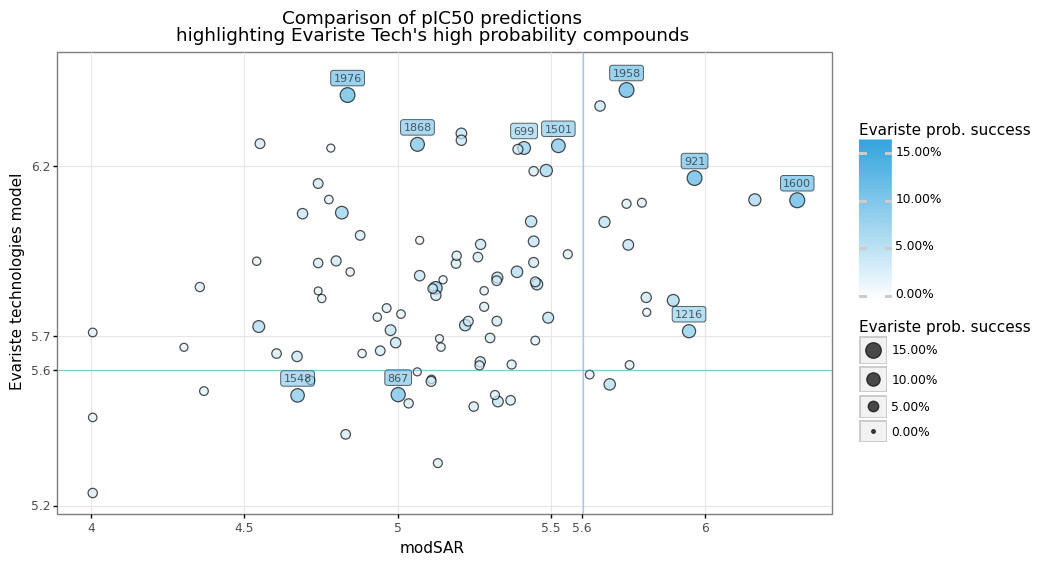

<ggplot: (8742748296744)>

In [13]:
from plotnine import *

def get_pctg_str(xs):
    return ["%.2f%%" % (100*x) for x in xs]
 

plot_df = gen_df.copy()
plot_df["modSAR_pred"] = pred
#plot_df = plot_df.sort_values(by=["potency_mu"], ascending=False).head(20)

x_interval = 0.5
y_interval = 0.5

x_breaks = np.arange(np.around(plot_df["modSAR_pred"].min(), 1), 
                     np.around(plot_df["modSAR_pred"].max(), 1) + x_interval,
                     0.5)
x_breaks = np.append(x_breaks, np.around(CUTOFF_ACTIVITY, 1))

y_breaks = np.arange(np.around(plot_df["potency_mu"].min(), 1), 
                     np.around(plot_df["potency_mu"].max(), 1) + y_interval,
                     0.5)
y_breaks = np.append(y_breaks, np.around(CUTOFF_ACTIVITY, 1))

g = (ggplot(plot_df, 
            aes(x="modSAR_pred", y="potency_mu", 
                fill="potency_prob_success", 
                size="potency_prob_success")) + 
     geom_point(alpha=0.7) + 
     geom_label(data=plot_df.sort_values("potency_prob_success", ascending=False).head(10),
                mapping=aes(label="original_id", y="potency_mu+0.05"),
                size=8, alpha=0.6) +
     geom_vline(xintercept=CUTOFF_ACTIVITY, alpha=0.5, color="#33a5dd") +
     geom_hline(yintercept=CUTOFF_ACTIVITY, alpha=0.5, color="#33a5dd") +
     
     scale_fill_gradient2(name="Evariste prob. success",
                          low="#f0f0f0", high="#33a5dd", 
                          limits=(0, 0.16),
                          breaks=np.arange(0, 0.2, 0.05),
                          labels=get_pctg_str) +
     scale_size(name="Evariste prob. success",
                limits=(0, 0.16),
                breaks=list(reversed(np.arange(0, 0.2, 0.05))),
                labels=get_pctg_str) +
     theme_bw() + 
     scale_x_continuous(name="modSAR", breaks=x_breaks) +
     scale_y_continuous(name="Evariste technologies model", breaks=y_breaks) +
     ggtitle("Comparison of pIC50 predictions\nhighlighting Evariste Tech's high probability compounds") +
     theme(figure_size=(10, 6),
           plot_title=element_text(hjust = -0.1),
           panel_grid_minor=element_blank()))

g

## Save results

In [68]:
plot_df[["original_id", "canonical_smiles", "modSAR_pred"]].to_csv("/mnt/data/2021_07_21_modSAR_predictions.csv", index=False)

# Plot compounds by original_id

In [70]:
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
drawing_opts = DrawingOptions()
drawing_opts.bgColor=None
drawing_opts.colorBonds = False
drawing_opts.includeAtomNumbers = True


def plot_compound(original_id, 
                  df=gen_df, 
                  id_column="original_id", 
                  smiles_column="canonical_smiles", 
                  drawing_opts=drawing_opts):
    
    mol = Chem.MolFromSmiles(df[df[id_column] == original_id][smiles_column].values[0])
    AllChem.Compute2DCoords(s4_template)
    AllChem.GenerateDepictionMatching2DStructure(mol, s4_template)
    return Chem.Draw.MolToImage(mol, size=(400, 300), kekulize=True, options=drawing_opts,)

In [201]:
gen_df[gen_df["potency_mu"] > 6.3]

,original_id,canonical_smiles,potency_mu,potency_sigma,LogD_mu,LogD_sigma,potency_prob_success,LogD_prob_success,prob_success
0,1976,Fc1ccc(CCOc2cncc3nnc(-c4cnc5[nH]ccc5c4)n23)cc1F,6.410090,0.511403,2.586254,0.626126,0.129416,0.961385,0.124418
9,1958,Fc1ccc(CCOc2cncc3nnc(-c4ccc(Cl)c(OC5CC5)c4)n23...,6.425008,0.518666,3.836005,0.811631,0.130499,0.575147,0.075056
28,1754,Fc1ccc(CCOc2cncc3nnc(-c4ccc(Cl)c(F)c4)n23)cc1F,6.377939,0.347584,2.980568,0.666765,0.047735,0.914343,0.043646


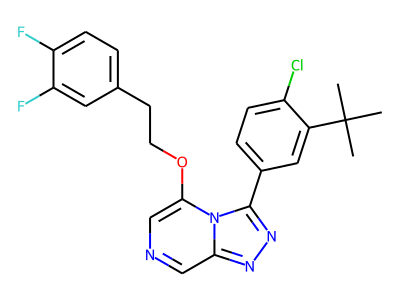

In [72]:
plot_compound(921)